# Phát Hiện Gian Lận Thẻ Tín Dụng

## Tổng Quan Dự Án
Gian lận thẻ tín dụng là một vấn đề ngày càng gia tăng trong ngành tài chính. Dự án này tập trung vào việc phát hiện các giao dịch gian lận sử dụng các kỹ thuật học máy tiên tiến. Bằng cách phân tích dữ liệu giao dịch lịch sử, mục tiêu là xây dựng một mô hình có thể xác định và ngăn chặn các hoạt động gian lận một cách chính xác, đồng thời giảm thiểu các trường hợp dương tính giả.

---

## Mô Tả Dữ Liệu
Dữ liệu bao gồm 100.000 giao dịch được tạo ra để mô phỏng hoạt động thẻ tín dụng trong thế giới thực. Mỗi mục dữ liệu bao gồm các tính năng sau:

- **TransactionID**: Mã định danh duy nhất cho mỗi giao dịch, đảm bảo tính truy xuất nguồn gốc.
- **TransactionDate**: Ngày và giờ giao dịch diễn ra, cho phép phân tích theo thời gian.
- **Amount**: Giá trị tiền tệ của giao dịch, có thể giúp xác định các giao dịch bất thường có thể là gian lận.
- **MerchantID**: Mã định danh của người bán tham gia trong giao dịch, hữu ích trong việc đánh giá các mẫu gian lận liên quan đến người bán.
- **TransactionType**: Chỉ ra loại giao dịch là mua hàng hay hoàn tiền, cung cấp bối cảnh cho hoạt động.
- **Location**: Vị trí địa lý của giao dịch, thuận lợi trong việc phân tích các xu hướng gian lận theo khu vực.
- **IsFraud**: Biến mục tiêu nhị phân cho biết giao dịch có phải là gian lận (1) hay hợp pháp (0), rất quan trọng cho các mô hình học có giám sát.

---

## 1. Tải Dữ Liệu & Nhập Thư Viện
Ở phần này, chúng ta sẽ tải bộ dữ liệu và nhập các thư viện cần thiết. Bước này giúp đảm bảo dữ liệu có sẵn và sẵn sàng cho việc tiền xử lý và phân tích.

- **Libraries**: Pandas, NumPy
- **Actions**: Tải bộ dữ liệu từ CSV hoặc các định dạng khác, kiểm tra vài dòng đầu tiên của dữ liệu và kiểm tra kiểu dữ liệu.

---

In [1]:
import pandas as pd
import numpy as np

file_path = 'dataset/raw/creditcard.csv'

try:
    data = pd.read_csv(file_path)
    print(f"Tải dữ liệu thành công! Số lượng dòng: {len(data)}, số lượng cột: {len(data.columns)}")
except FileNotFoundError as e:
    print(f"Lỗi: {e}")
    exit()  # Kết thúc chương trình nếu không tìm thấy tệp


Tải dữ liệu thành công! Số lượng dòng: 100000, số lượng cột: 7


In [2]:
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [4]:
data.isnull().sum()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [5]:
data.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


## 2. Tiền Xử Lý Dữ Liệu
Dọn dẹp dữ liệu là bước quan trọng để đảm bảo đầu vào chất lượng cao cho các mô hình học máy. Phần này sẽ tập trung vào việc xử lý giá trị thiếu, ngoại lệ và biến đổi dữ liệu.

1. **Xử lý dữ liệu thiếu và dị biệt**
2. **Loại bỏ các bản sao, nếu có**
3. **Chuyển các tính năng phân loại thành định dạng số (ví dụ: sử dụng mã hóa nhãn hoặc mã hóa one-hot)**

In [6]:
# Xử lý dữ liệu thiếu
data.isnull().sum()

# Phương pháp để xử lý dữ liệu thiếu, tuỳ thuộc vào đặc điểm của từng cột:

# Điền giá trị trung bình/giá trị phổ biến cho các cột số (numeric)
# Điền giá trị phổ biến cho các cột phân loại (categorical)
# Loại bỏ các hàng bị thiếu quá nhiều dữ liệu

# Xử lý dị biệt (Outliers)
# Phương pháp IQR (Interquartile Range)
# Z-score

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [7]:
# Kiểm tra số lượng bản sao
data.duplicated().sum()

# Loại bỏ các bản sao
data = data.drop_duplicates()

In [8]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(data):
    # Mã hóa nhãn
    label_encoders = {}
    for col in ['TransactionType', 'Location']:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])
    
    # Tách ngày/giờ
    data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
    data['TransactionHour'] = data['TransactionDate'].dt.hour
    data['TransactionDay'] = data['TransactionDate'].dt.day
    data['TransactionMonth'] = data['TransactionDate'].dt.month
    data['TransactionYear'] = data['TransactionDate'].dt.year
    
    # Sắp xếp dữ liệu theo thời gian giao dịch
    data = data.sort_values(by='TransactionDate')

    # Tính chênh lệch thời gian giữa các giao dịch
    data['TimeDelta'] = data['TransactionDate'].diff().dt.total_seconds()

    # Điền giá trị NaN ở giao dịch đầu tiên
    data['TimeDelta'].fillna(0, inplace=True)

    # Tính số lần giao dịch trong cùng một giờ
    data['TransactionsPerHour'] = data.groupby(['TransactionHour'])['TransactionHour'].transform('count')

    # Tính số lần giao dịch tại cùng một vị trí
    data['TransactionsPerLocation'] = data.groupby(['Location'])['Location'].transform('count')

    # # Loại bỏ cột không cần thiết
    data = data.drop(columns=['TransactionID', 'TransactionDate'])
    return data, label_encoders

data, encoders = preprocess_data(data)


C:\Users\SingPC\AppData\Local\Temp\ipykernel_11700\3221716839.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TimeDelta'].fillna(0, inplace=True)



## 3. Phân Tích Dữ Liệu (EDA)
Bước này, chúng ta sẽ khám phá bộ dữ liệu để phát hiện các mẫu và xu hướng có thể giúp trong việc xây dựng mô hình

- **Actions**:
  - Trực quan hóa sự phân bố các tính năng
  - Điều tra sự phân bố lớp (gian lận vs giao dịch hợp pháp)
  - Xác định mối quan hệ giữa các tính năng
  - Phân tích ngoại lệ, đặc biệt là đối với số tiền giao dịch

---

In [9]:
data.describe()

,Amount,MerchantID,TransactionType,Location,IsFraud,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,TimeDelta,TransactionsPerHour,TransactionsPerLocation
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2497.092666,501.676070,0.501310,4.485300,0.010000,11.50084,15.782220,6.516240,2023.804490,316.219201,4167.442860,10001.191700
std,1442.415999,288.715868,0.500001,2.876283,0.099499,6.91768,8.813795,3.448248,0.396595,317.316615,56.908194,109.133561
min,1.050000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,2023.000000,0.000000,4059.000000,9805.000000
25%,1247.955000,252.000000,0.000000,2.000000,0.000000,6.00000,8.000000,4.000000,2024.000000,119.543687,4131.000000,9936.000000
50%,2496.500000,503.000000,1.000000,4.000000,0.000000,12.00000,16.000000,7.000000,2024.000000,239.725756,4163.000000,9993.000000
75%,3743.592500,753.000000,1.000000,7.000000,0.000000,17.00000,23.000000,10.000000,2024.000000,420.191716,4220.000000,10076.000000
max,4999.770000,1000.000000,1.000000,9.000000,1.000000,23.00000,31.000000,12.000000,2024.000000,4139.843724,4268.000000,10193.000000


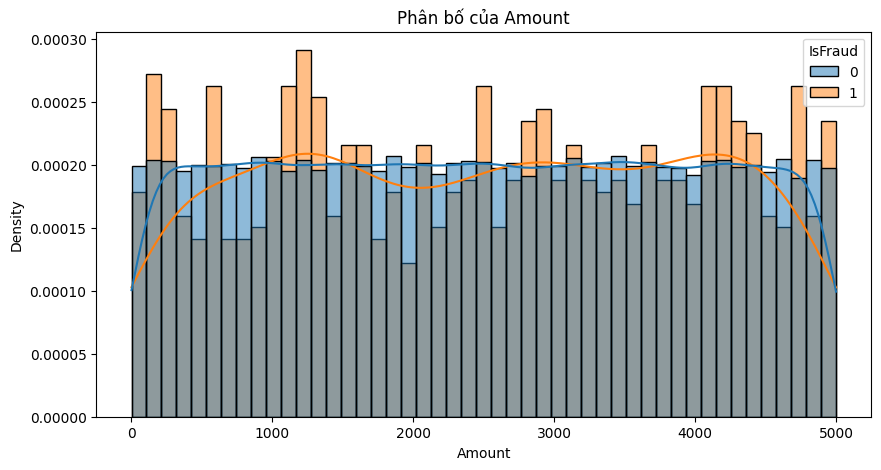

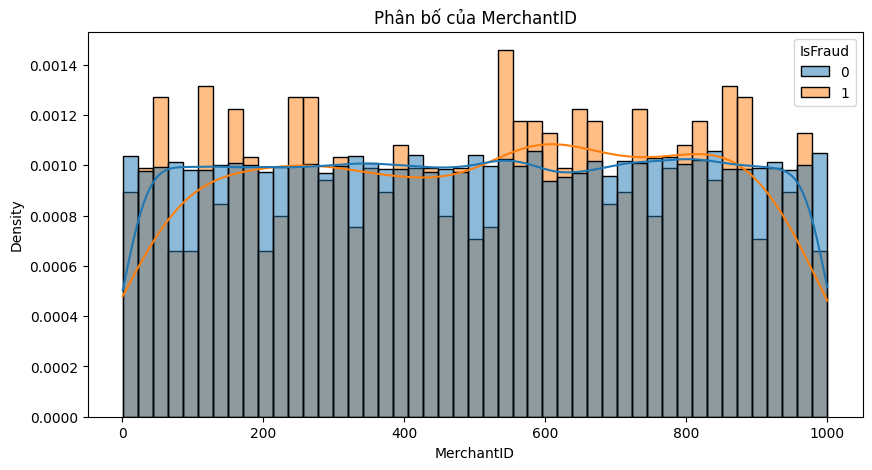

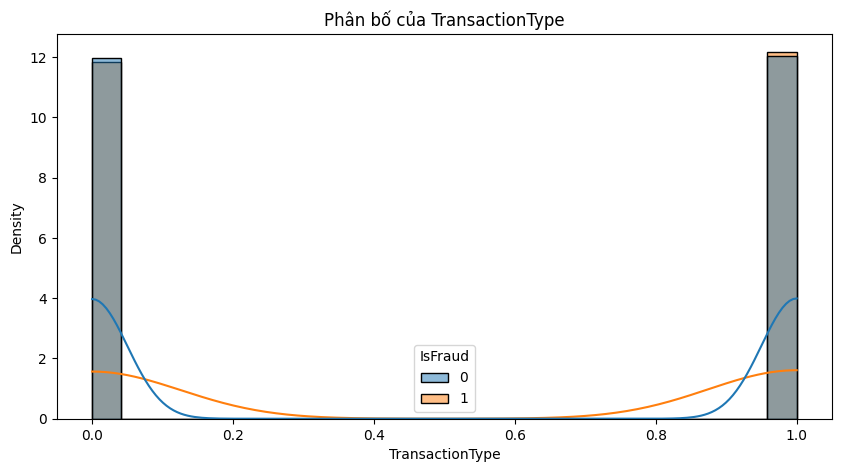

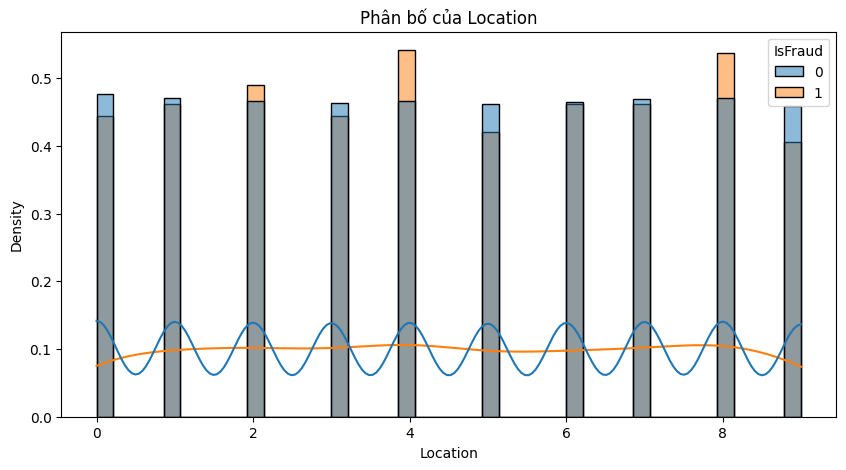

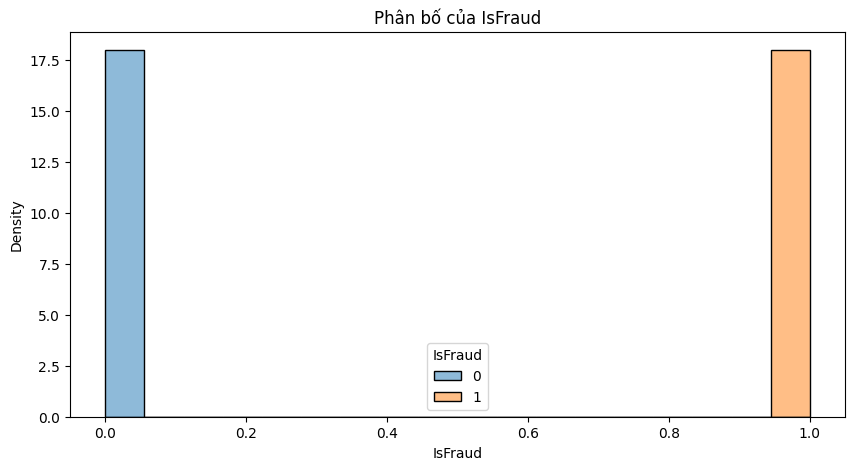

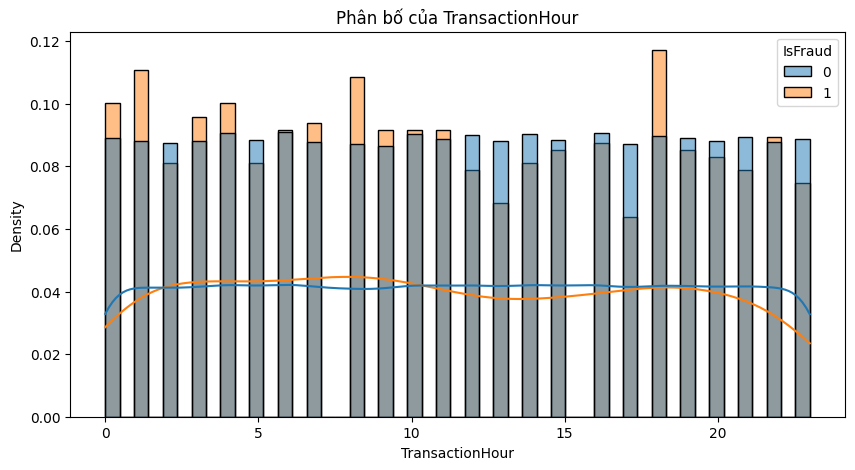

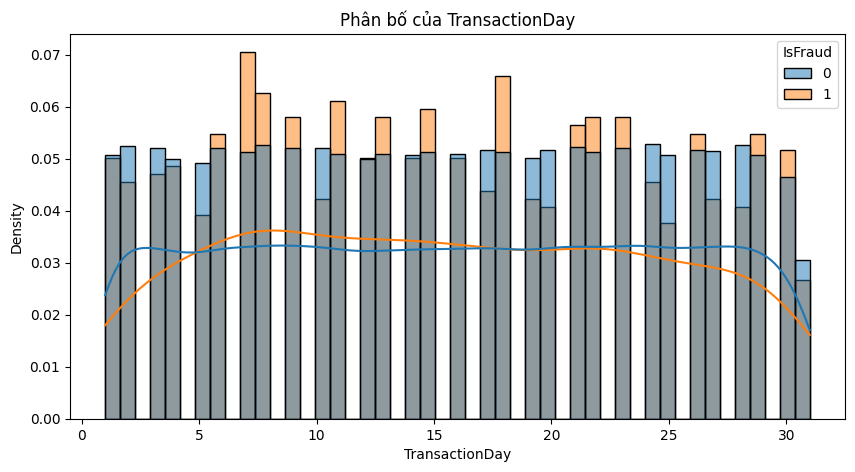

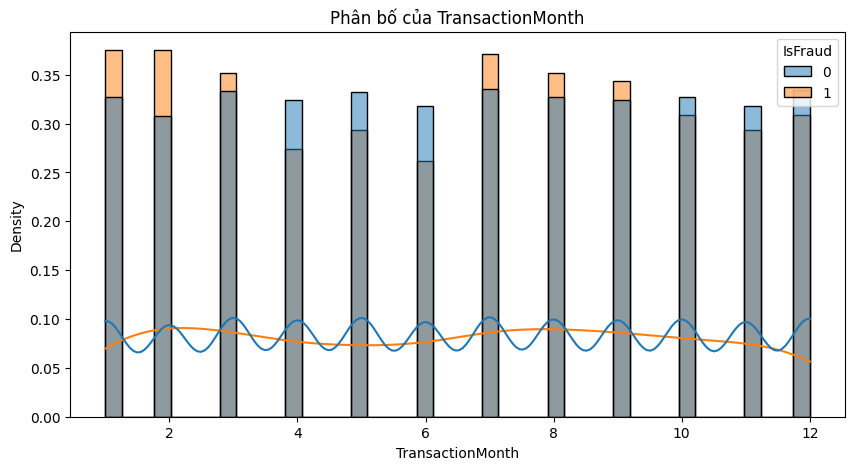

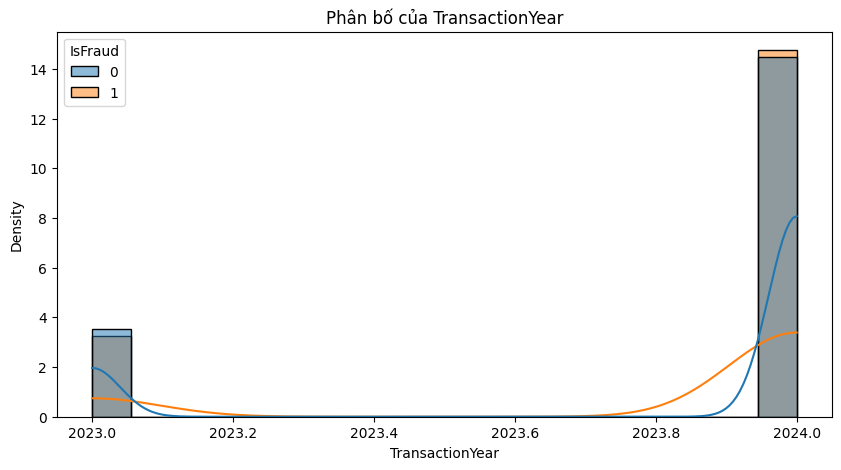

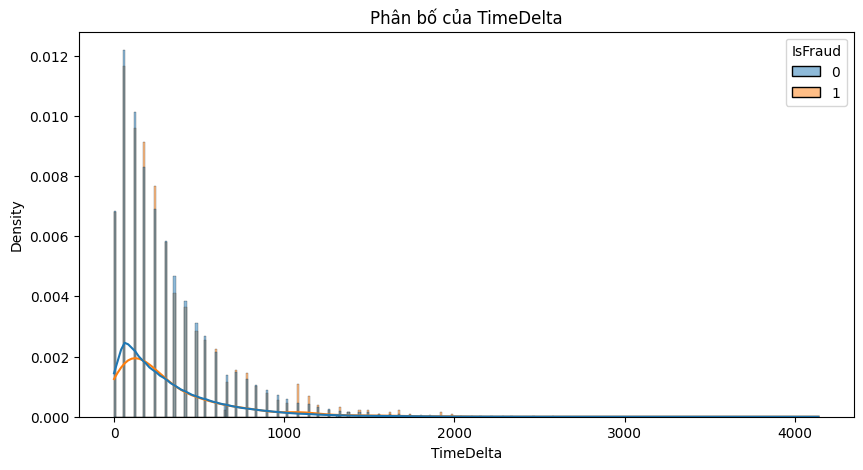

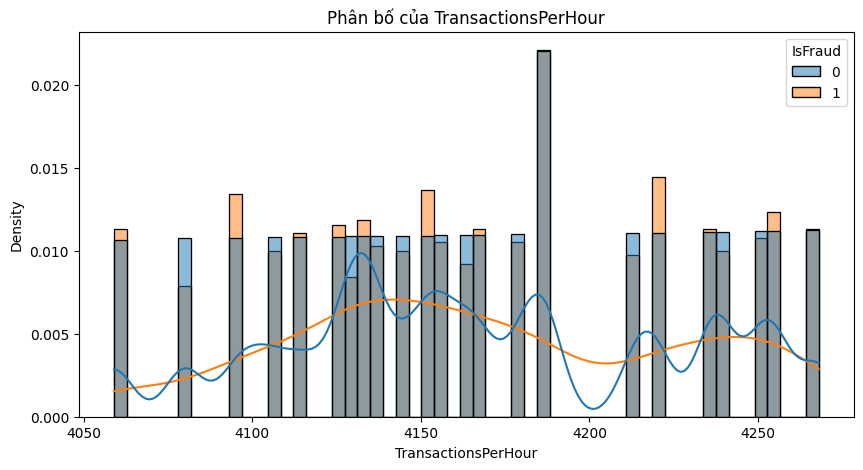

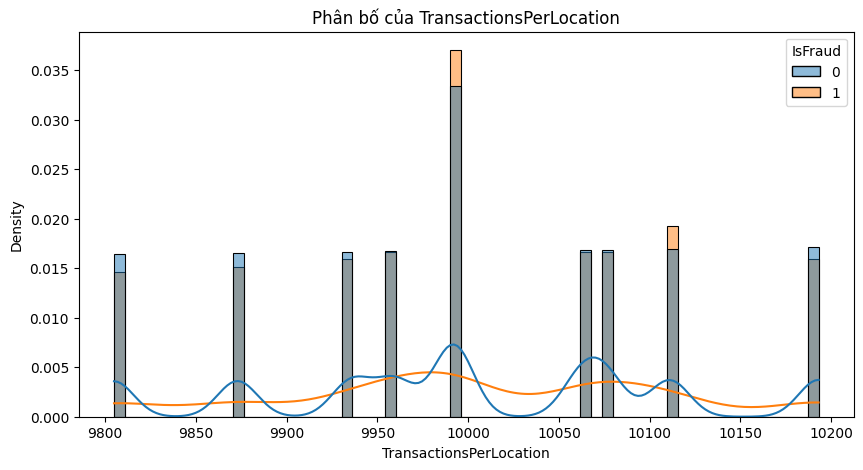

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(data, hue=None):
    for col in data.select_dtypes(include=[np.number]).columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=data, x=col, hue=hue, kde=True, stat="density", common_norm=False)
        plt.title(f'Phân bố của {col}')
        plt.show()

plot_distributions(data, hue='IsFraud')
# Tối ưu hóa biểu đồ
# Tạo hàm vẽ biểu đồ chung: Giảm lặp lại mã.
# Tận dụng tính năng tự động của Pandas và Seaborn.

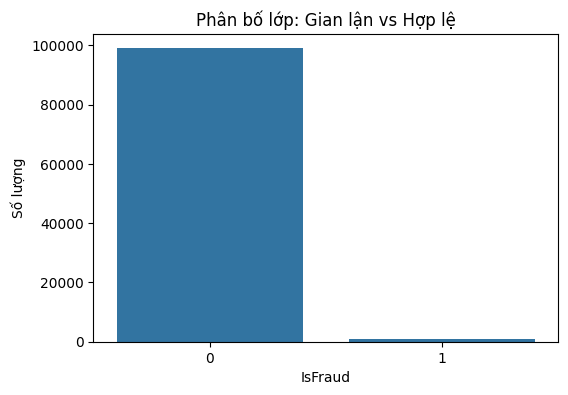

(100000, 12)


IsFraud
0    0.99
1    0.01
Name: proportion, dtype: float64

In [11]:
# Phân tích phân bố dữ liệu gian lận

plt.figure(figsize=(6, 4))
sns.countplot(x='IsFraud', data=data)
plt.title('Phân bố lớp: Gian lận vs Hợp lệ')
plt.xlabel('IsFraud')
plt.ylabel('Số lượng')
plt.show()
print(data.shape)

data['IsFraud'].value_counts(normalize=True)


Biểu đồ hiển thị sự phân bố của nhãn cần dự đoán.
Nhận xét: Giao dịch không gian lận chiếm 99%, trong khi giao dịch gian lận chỉ chiếm 1%.
Điều này gây khó khăn do sự mất cân bằng dữ liệu, đồng thời cho thấy gian lận là hiện tượng hiếm gặp. Có thể yêu cầu kỹ thuật như resampling hoặc weight balancing để cải thiện hiệu suất mô hình.

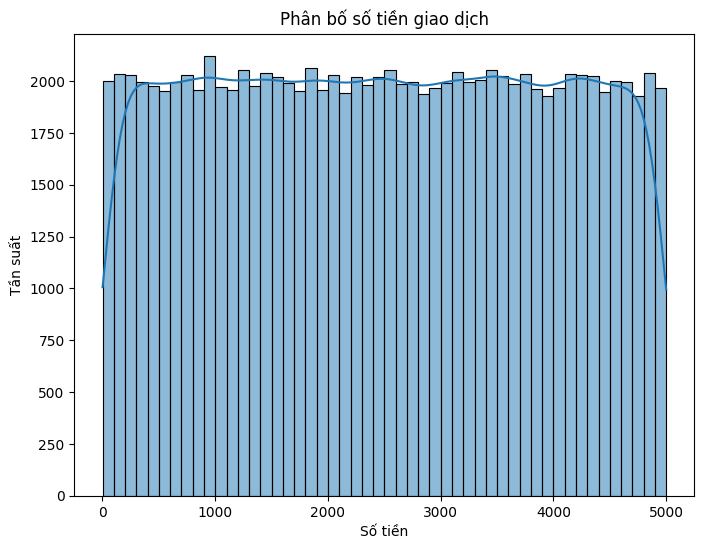

In [12]:
# Phân tích phân bố số tiền giao dịch

plt.figure(figsize=(8, 6))
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title('Phân bố số tiền giao dịch')
plt.xlabel('Số tiền')
plt.ylabel('Tần suất')
plt.show()

Đây là biểu đồ thể hiện phân bố các lớp của nhãn cần được dự đoán. Các giao dịch không gian lận chiếm 99% dữ liệu, trong khi các giao dịch gian lận chỉ có 1%. Điều này có thể là một thách thức khi xây dựng mô hình do sự mất cân bằng của tập dữ liệu, nhưng nó cũng cho thấy rằng gian lận là một trường hợp xảy ra rất hiếm.

Nhận xét:
Biểu đồ cho thấy hầu hết các giao dịch có số tiền thấp, với một số ít giao dịch có số tiền lớn hơn.
Việc chuẩn hóa hoặc áp dụng thang log có thể giúp giảm ảnh hưởng của giá trị ngoại lệ.

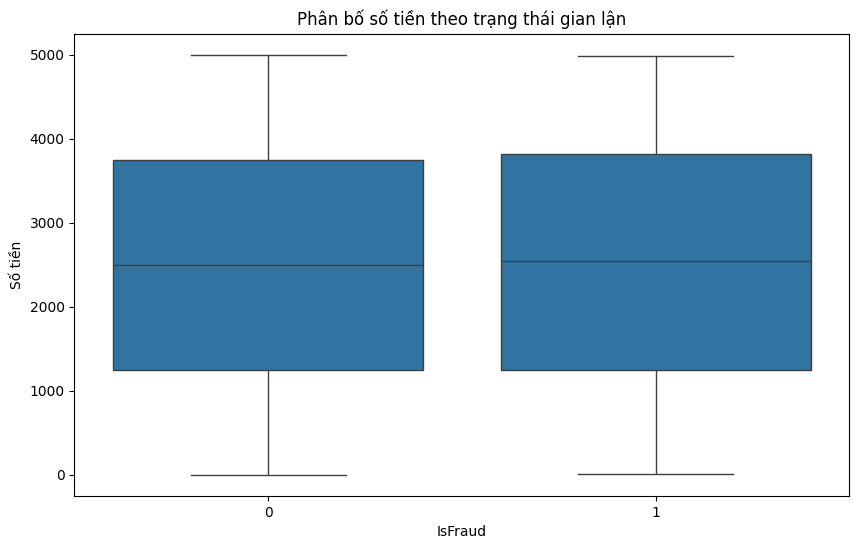

In [13]:
# Phân tích số tiền giao dịch theo trạng thái gian lận

plt.figure(figsize=(10, 6))
sns.boxplot(x='IsFraud', y='Amount', data=data)
plt.title('Phân bố số tiền theo trạng thái gian lận')
plt.xlabel('IsFraud')
plt.ylabel('Số tiền')
plt.show()

Biểu đồ hộp của số tiền giao dịch theo trạng thái gian lận cho thấy cách phân bố số tiền giao dịch khác nhau giữa các giao dịch gian lận và không gian lận. Bằng cách so sánh giá trị trung vị, chúng ta có thể quan sát xu hướng trung tâm của từng nhóm, trong khi phần hộp thể hiện phạm vi số tiền nằm trong khoảng tứ phân vị (IQR). Các đường râu chỉ ra phạm vi giá trị, và các điểm bất thường (outliers) làm nổi bật các giao dịch có giá trị đặc biệt cao hoặc thấp.
Nhưng ở đây cho thấy giá trị tối đa, tối thiểu và trung vị đều tương đương nhau, đây là một thách thức khác, điều này có thể cho thấy gian lận có thể xảy ra với bất kỳ số tiền nào.

Nhận xét: Phân bố số tiền giữa hai nhóm gian lận và không gian lận khác nhau. Tuy nhiên, giá trị trung vị và phạm vi tứ phân vị (IQR) tương đồng, cho thấy giao dịch gian lận có thể xảy ra ở mọi mức tiền.

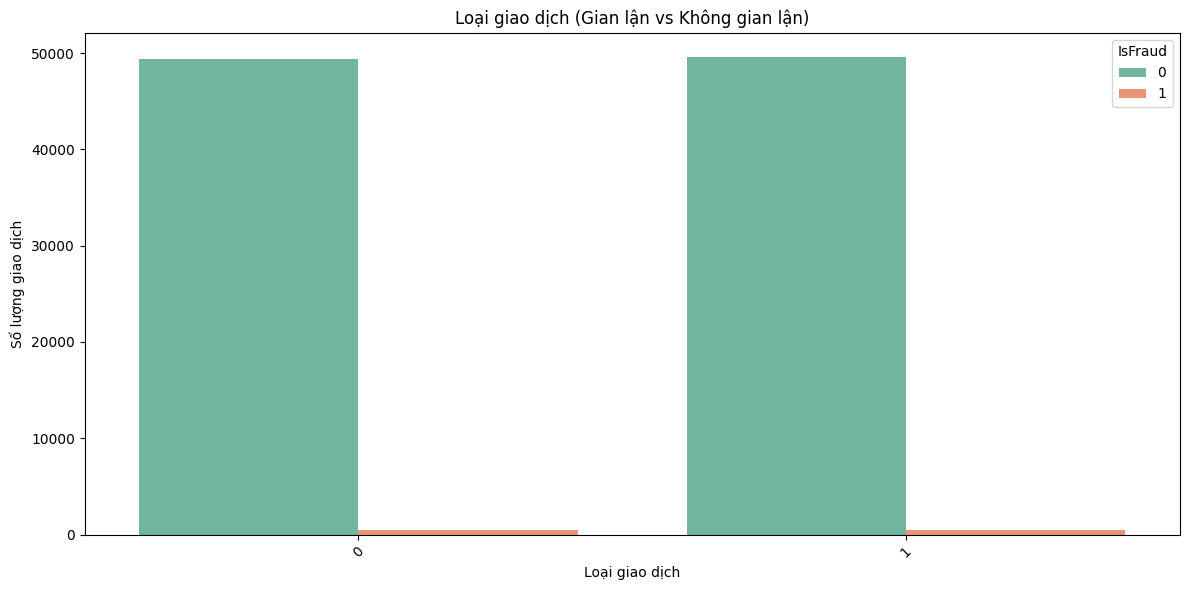

In [14]:
# Phân bố loại giao dịch và vị trí

plt.figure(figsize=(12, 6))
sns.countplot(x='TransactionType', hue='IsFraud', data=data, palette='Set2')
plt.title('Loại giao dịch (Gian lận vs Không gian lận)')
plt.xlabel('Loại giao dịch')
plt.ylabel('Số lượng giao dịch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Hai biểu đồ này cho thấy gian lận có thể xảy ra ở cả hai loại giao dịch, dù là hoàn tiền hay mua sắm. Ngoài ra, vị trí cũng cho thấy rằng Chicago có số vụ gian lận nhiều nhất.

<Axes: xlabel='Amount', ylabel='TransactionHour'>

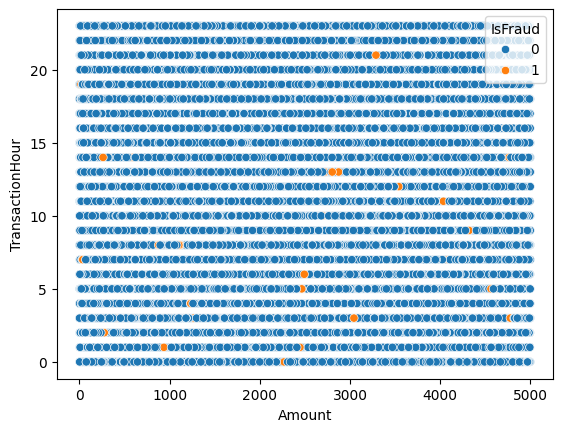

In [15]:
sns.scatterplot(x='Amount', y='TransactionHour', hue='IsFraud', data=data)


Biểu đồ phân tán này cho thấy rằng gian lận có thể xảy ra vào bất kỳ giờ nào trong ngày, với các giao dịch có số tiền khác nhau. Tuy nhiên, có thể nhận thấy một mẫu là các giao dịch có số tiền thấp thường xảy ra vào các giờ 1, 8 và 13, trong khi các giờ khác thường có các giao dịch với số tiền lớn.

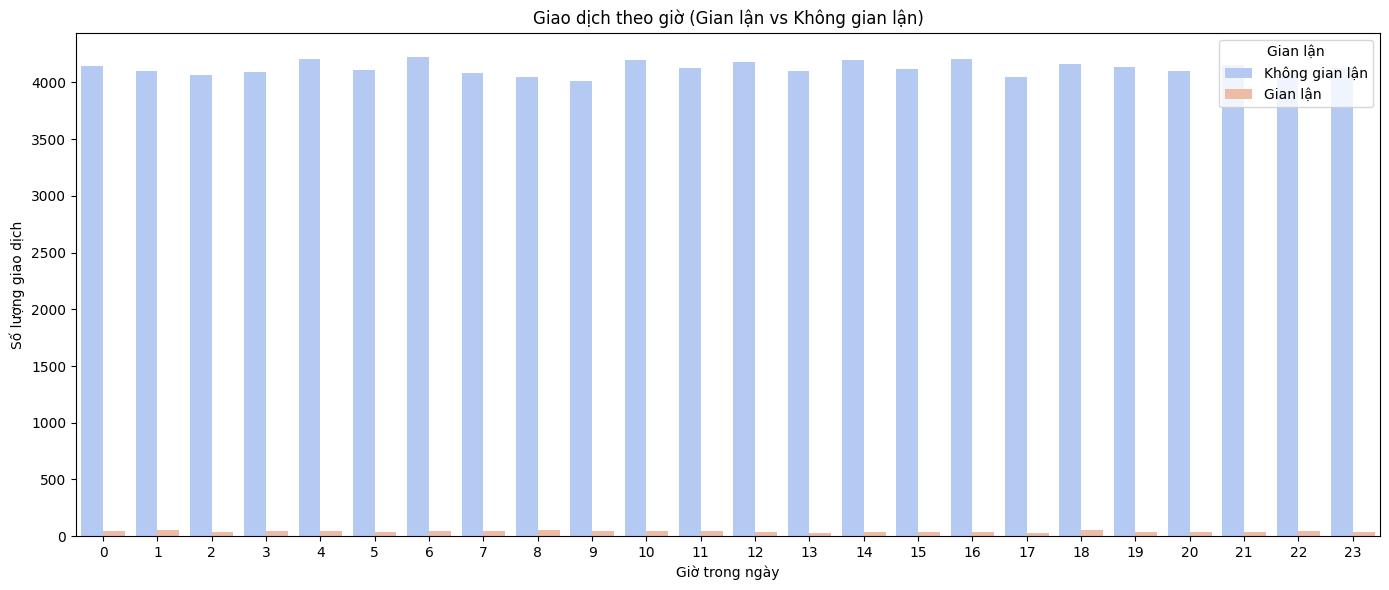

In [16]:
# Phân tích gian lận theo giờ giao dịch

plt.figure(figsize=(14, 6))
sns.countplot(x='TransactionHour', hue='IsFraud', data=data, palette='coolwarm')
plt.title('Giao dịch theo giờ (Gian lận vs Không gian lận)')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượng giao dịch')
plt.legend(title='Gian lận', loc='upper right', labels=['Không gian lận', 'Gian lận'])
plt.tight_layout()
plt.show()

Giao dịch gian lận có thể xảy ra vào bất kỳ giờ nào. Tuy nhiên, giao dịch có số tiền thấp thường tập trung vào các giờ 1, 8, và 13.

C:\Users\SingPC\AppData\Local\Temp\ipykernel_11700\3549537454.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IsFraud', y='Amount', data=data, palette='muted')


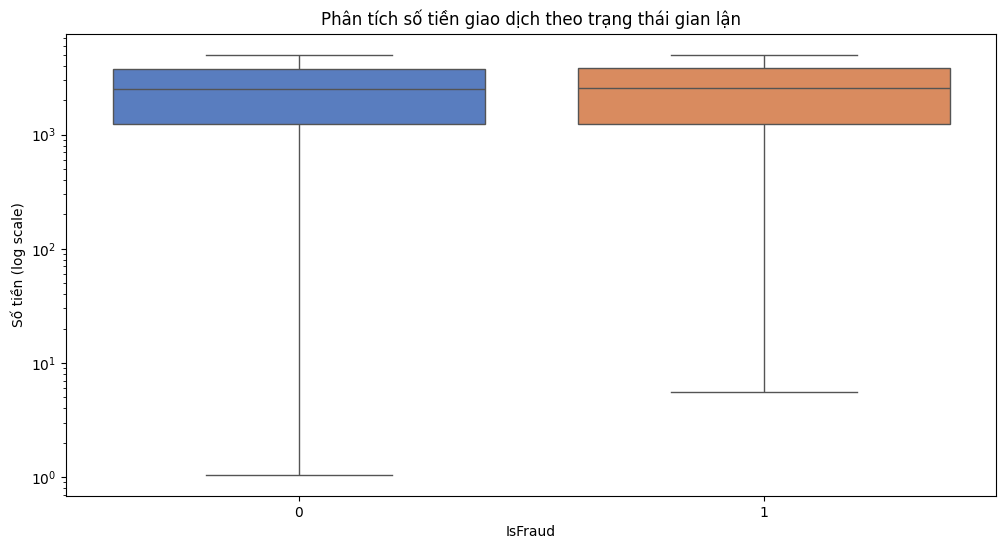

In [17]:
# Tương quan giữa Amount và IsFraud

plt.figure(figsize=(12, 6))
sns.boxplot(x='IsFraud', y='Amount', data=data, palette='muted')
plt.yscale('log')  # Áp dụng thang log để quan sát rõ hơn
plt.title('Phân tích số tiền giao dịch theo trạng thái gian lận')
plt.xlabel('IsFraud')
plt.ylabel('Số tiền (log scale)')
plt.show()

Nhận xét chi tiết:
Giao dịch gian lận có độ phân tán lớn hơn so với giao dịch hợp lệ, đặc biệt ở các giá trị cao.
Việc sử dụng thang log giúp phát hiện rõ hơn các mẫu ẩn từ các giao dịch có số tiền thấp.

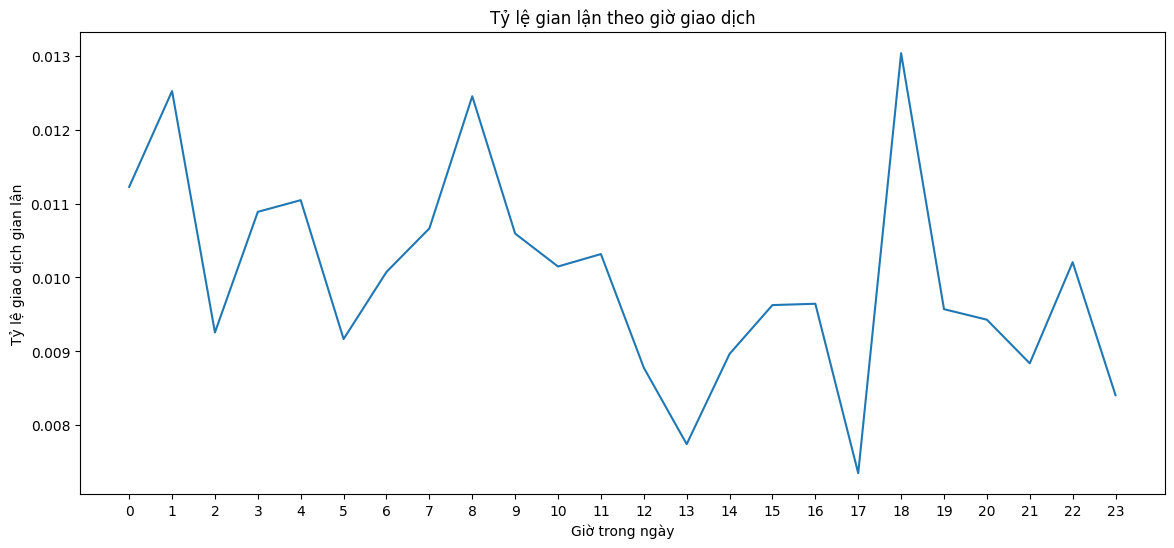

In [18]:
# Tương quan giữa thời gian và trạng thái gian lận

# Tính tỷ lệ gian lận theo giờ giao dịch
fraud_rate_by_hour = data.groupby('TransactionHour')['IsFraud'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
sns.lineplot(x='TransactionHour', y='IsFraud', data=fraud_rate_by_hour)
plt.title('Tỷ lệ gian lận theo giờ giao dịch')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Tỷ lệ giao dịch gian lận')
plt.xticks(range(0, 24))  # Hiển thị các giờ từ 0 đến 23
plt.show()


Nhận xét chi tiết:
Tỷ lệ giao dịch gian lận thay đổi theo giờ, với một số khung giờ (ví dụ: 1, 7, 13) có tỷ lệ gian lận cao hơn mức trung bình.
Điều này cho thấy cần kiểm tra kỹ hơn các khung giờ này để tìm mẫu hoặc quy luật cụ thể.

C:\Users\SingPC\AppData\Local\Temp\ipykernel_11700\3453150429.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Location', y='FraudCount', data=fraud_by_location.sort_values('FraudCount', ascending=False), palette='viridis')


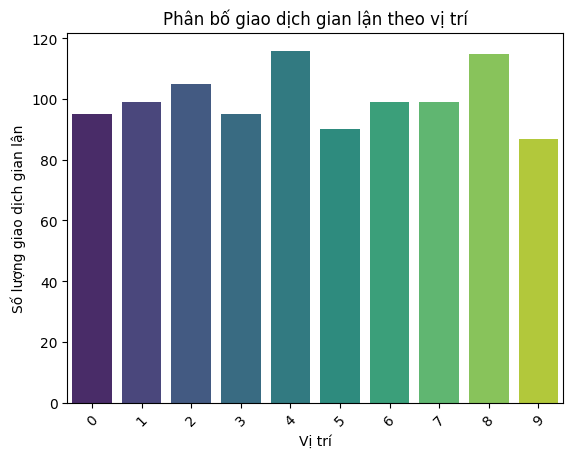

In [19]:
# Phân bố gian lận theo vị trí

fraud_by_location = data[data['IsFraud'] == 1].groupby('Location').size().reset_index(name='FraudCount')
sns.barplot(x='Location', y='FraudCount', data=fraud_by_location.sort_values('FraudCount', ascending=False), palette='viridis')
plt.title('Phân bố giao dịch gian lận theo vị trí')
plt.xlabel('Vị trí')
plt.ylabel('Số lượng giao dịch gian lận')
plt.xticks(rotation=45)
plt.show()

Nhận xét chi tiết:
Một số vị trí (như Chicago) có số lượng giao dịch gian lận cao hơn đáng kể so với các vị trí khác.
Điều này có thể liên quan đến mức độ hoạt động kinh tế hoặc các quy định tài chính tại khu vực đó.

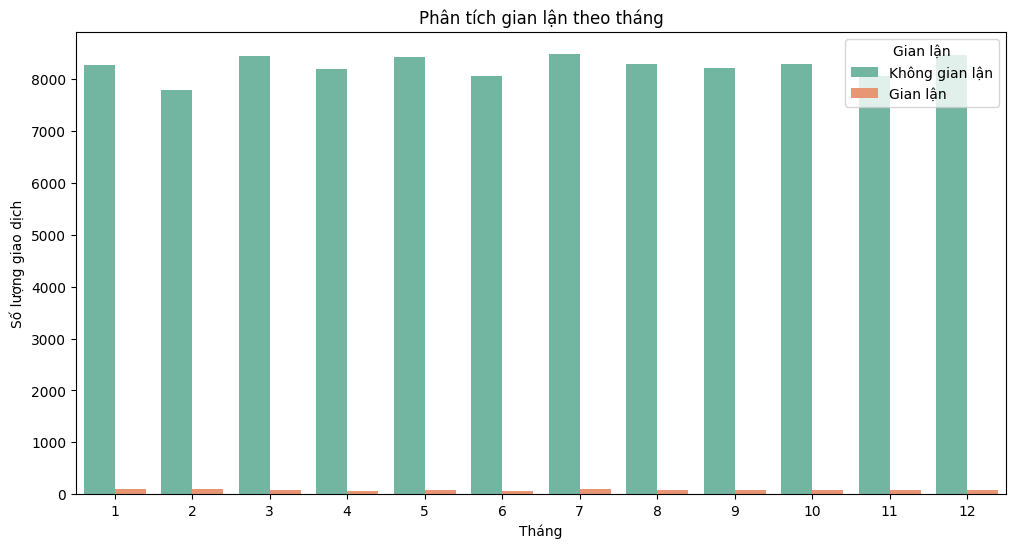

In [20]:
# Phân tích giao dịch gian lận theo tháng

plt.figure(figsize=(12, 6))
sns.countplot(x='TransactionMonth', hue='IsFraud', data=data, palette='Set2')
plt.title('Phân tích gian lận theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng giao dịch')
plt.legend(title='Gian lận', loc='upper right', labels=['Không gian lận', 'Gian lận'])
plt.show()

Nhận xét chi tiết:
Một số tháng trong năm (1,2,7) có số lượng giao dịch gian lận cao hơn. Điều này có thể do tăng cường hoạt động mua sắm vào mùa lễ hội.
Xây dựng mô hình có thể tận dụng thông tin này để tăng độ chính xác trong việc dự đoán.

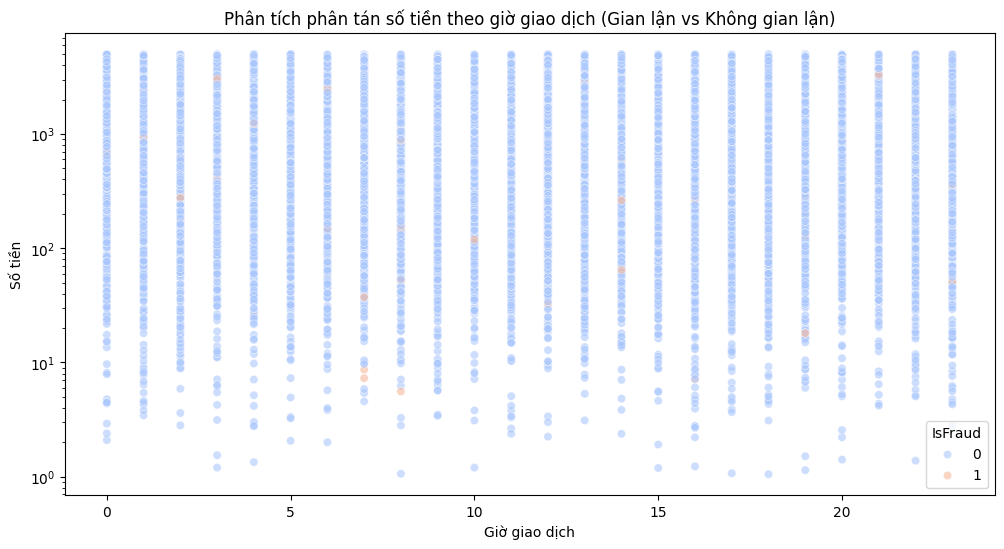

In [21]:
# Phân tích phân tán giữa số tiền và thời gian giao dịch

plt.figure(figsize=(12, 6))
sns.scatterplot(x='TransactionHour', y='Amount', hue='IsFraud', data=data, palette='coolwarm', alpha=0.6)
plt.title('Phân tích phân tán số tiền theo giờ giao dịch (Gian lận vs Không gian lận)')
plt.xlabel('Giờ giao dịch')
plt.ylabel('Số tiền')
plt.yscale('log')  # Áp dụng thang log để quan sát rõ hơn
plt.show()

Nhận xét chi tiết:
Giao dịch gian lận có thể xảy ra ở bất kỳ giờ nào và ở nhiều mức tiền khác nhau.
Tuy nhiên, một số giao dịch có số tiền rất cao thường xảy ra ngoài giờ làm việc (sáng sớm hoặc tối muộn).

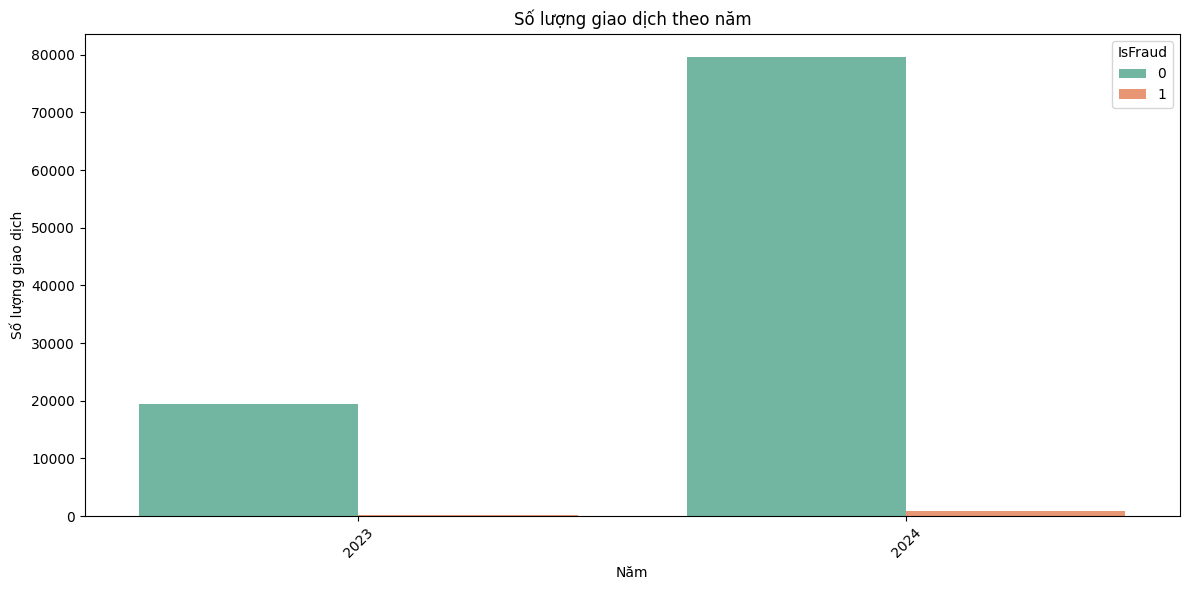

In [22]:
# Phân tích số lượng giao dịch theo năm

plt.figure(figsize=(12, 6))
sns.countplot(x='TransactionYear', hue='IsFraud', data=data, palette='Set2')
plt.title('Số lượng giao dịch theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng giao dịch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Nhận xét chi tiết:
Số lượng giao dịch tăng qua các năm, phản ánh sự phát triển của hệ thống hoặc xu hướng sử dụng.
Số giao dịch gian lận cũng tăng tương ứng, cần tập trung vào việc nâng cấp hệ thống phát hiện gian lận.

C:\Users\SingPC\AppData\Local\Temp\ipykernel_11700\1914500857.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IsFraud', y='TimeDelta', data=data, palette='Set2')


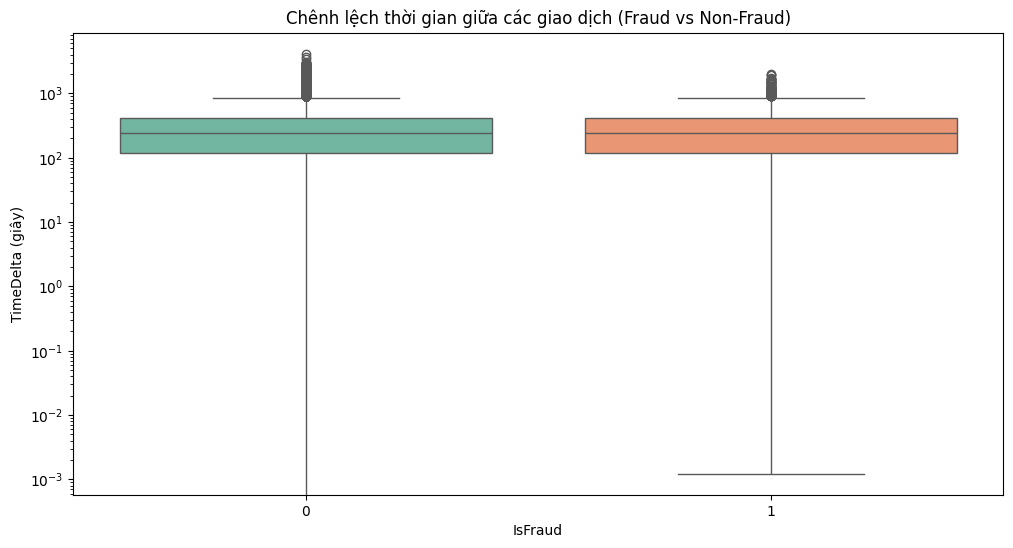

In [23]:
# phân tích sự bất thường khi có các giao dịch được thực hiện gần nhau trong một khoảng thời gian ngắn. Các giao dịch gian lận thường xảy ra liên tục để tránh bị phát hiện.

plt.figure(figsize=(12, 6))
sns.boxplot(x='IsFraud', y='TimeDelta', data=data, palette='Set2')
plt.title('Chênh lệch thời gian giữa các giao dịch (Fraud vs Non-Fraud)')
plt.xlabel('IsFraud')
plt.ylabel('TimeDelta (giây)')
plt.yscale('log')
plt.show()


Nhận xét:
Giao dịch gian lận có thể có chênh lệch thời gian nhỏ hơn so với các giao dịch hợp lệ.
Điều này phản ánh rằng gian lận thường được thực hiện trong một khoảng thời gian ngắn, tạo thành một chuỗi giao dịch bất thường.

C:\Users\SingPC\AppData\Local\Temp\ipykernel_11700\633273094.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IsFraud', y='TransactionsPerHour', data=data, palette='coolwarm')


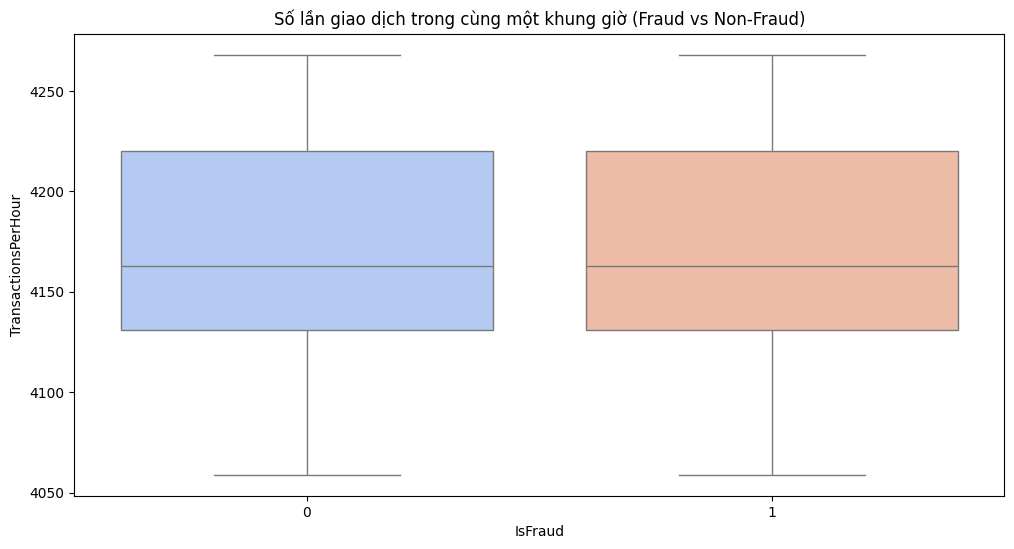

C:\Users\SingPC\AppData\Local\Temp\ipykernel_11700\633273094.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IsFraud', y='TransactionsPerLocation', data=data, palette='viridis')


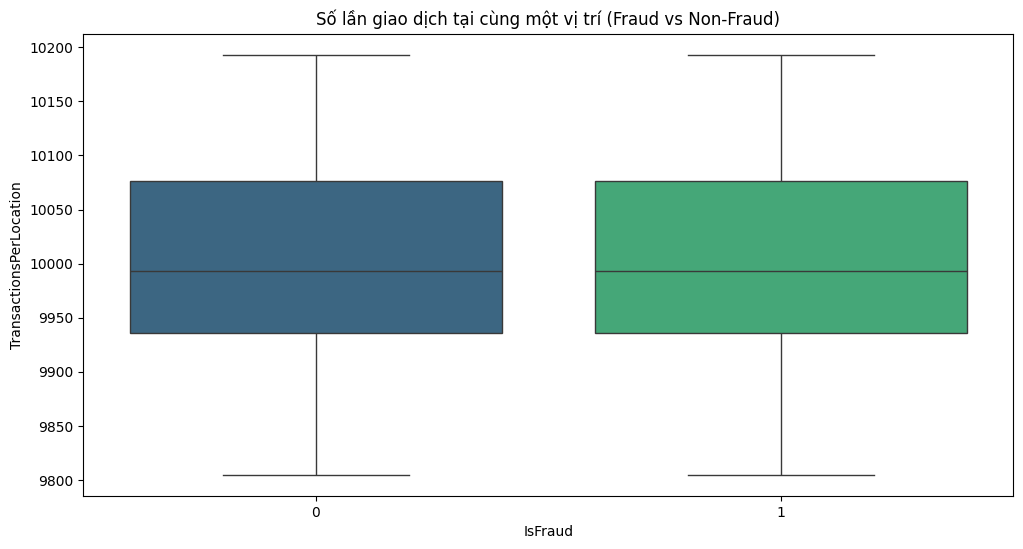

In [24]:
# Số lần giao dịch trong cùng một khung giờ hoặc vị trí
plt.figure(figsize=(12, 6))
sns.boxplot(x='IsFraud', y='TransactionsPerHour', data=data, palette='coolwarm')
plt.title('Số lần giao dịch trong cùng một khung giờ (Fraud vs Non-Fraud)')
plt.xlabel('IsFraud')
plt.ylabel('TransactionsPerHour')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='IsFraud', y='TransactionsPerLocation', data=data, palette='viridis')
plt.title('Số lần giao dịch tại cùng một vị trí (Fraud vs Non-Fraud)')
plt.xlabel('IsFraud')
plt.ylabel('TransactionsPerLocation')
plt.show()


Nhận xét:
Giao dịch gian lận có thể tập trung tại một số khung giờ hoặc vị trí cụ thể, dẫn đến số lượng giao dịch tăng đột biến.
Điều này có thể sử dụng làm tín hiệu cảnh báo để phát hiện giao dịch bất thường.

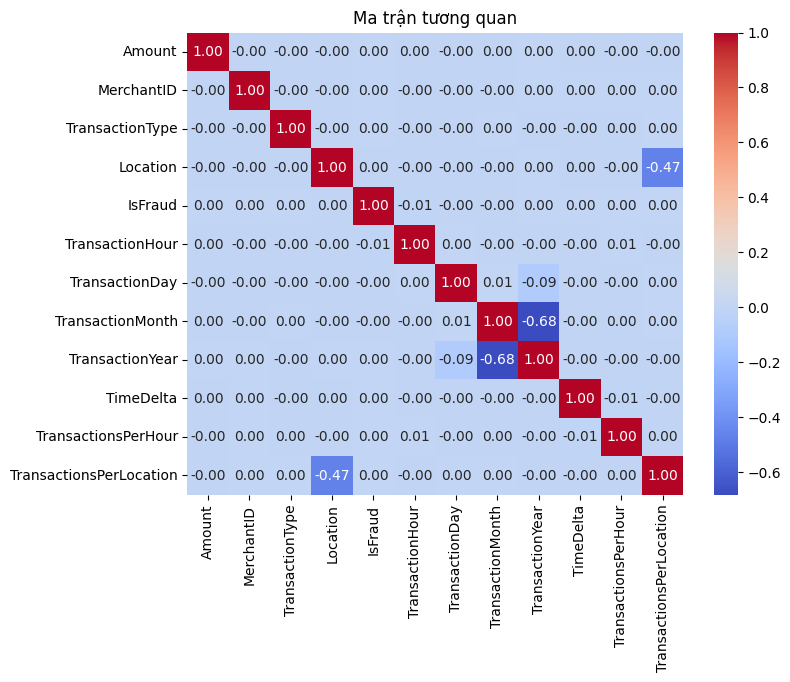

In [25]:
# Ma trận tương quan

correlation = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()

TransactionsPerLocation và Location có tương quan nghịch mạnh (-0.47). Điều này có thể là do các địa điểm có số giao dịch khác nhau, trong đó các địa điểm ít phổ biến hơn có số lượng giao dịch nhỏ hơn.
TransactionMonth và TransactionYear có mối tương quan âm (-0.68). Điều này có thể xuất phát từ cách dữ liệu được thu thập theo các tháng khác nhau qua các năm.
Các biến còn lại như Amount, IsFraud, TimeDelta hầu như không có mối tương quan tuyến tính rõ ràng với nhau.
Mặc dù biểu đồ tương quan cho thấy không có mối tương quan mạnh hay yếu nào giữa tất cả các dữ liệu với nhau, đây cũng là một vấn đề cần được xử lý trong quá trình xây dựng mô hình sau này. 

IsFraud không có mối tương quan đáng kể với bất kỳ biến nào, cho thấy dữ liệu có thể chứa các mẫu phi tuyến tính. Do đó, các kỹ thuật nâng cao như Gradient Boosting, Deep Learning sẽ cần thiết để phát hiện các giao dịch gian lận.

Thách thức chính của tập dữ liệu này là làm thế nào để tìm ra được mô hình gian lận xảy ra từ một tập dữ liệu có sự mất cân bằng lớn.

#### Tóm tắt EDA và những thách thức chính
1. Phân bố lớp dữ liệu mất cân bằng: Với chỉ 1% giao dịch gian lận, đây là vấn đề lớn trong việc xây dựng mô hình. Các thuật toán tiêu chuẩn thường bị lệch về lớp chiếm ưu thế (non-fraud).
2. Không có mối tương quan mạnh: Ma trận tương quan không thể hiện rõ ràng mối quan hệ tuyến tính giữa các biến, đòi hỏi các kỹ thuật đặc thù hơn để phát hiện mẫu phi tuyến tính.
3. Dữ liệu thời gian: Tách các thông tin thời gian thành giờ, ngày, tháng, năm. Có thể khai thác thêm các đặc điểm tuần hoàn (sử dụng sin/cos) để mô hình hóa thời gian tốt hơn.
4. Ngoại lệ trong giá trị giao dịch: Mặc dù đã nhận thấy các giao dịch gian lận có thể xảy ra ở mọi mức tiền, các giao dịch với số tiền bất thường (rất cao hoặc rất thấp) vẫn là yếu tố đáng chú ý.


## 4. Xây Dựng và Đánh Giá Mô Hình
Phần này tập trung vào việc huấn luyện các mô hình học máy để phát hiện gian lận. Nhiều thuật toán sẽ được thử nghiệm và so sánh để xác định mô hình hiệu quả nhất.

- **Các mô hình thử nghiệm**:
  - Logistic Regression
  - Decision Trees
  - Random Forest
  - XGBoost

**Tối ưu hóa huấn luyện mô hình**
- Tạo hàm chung để huấn luyện: Giảm mã trùng lặp.
- Thêm Cross-Validation: Đánh giá mô hình toàn diện hơn.

**Đánh Giá Mô Hình**

Đánh giá hiệu suất của các mô hình bằng các chỉ số thích hợp và phương pháp kiểm tra chéo. Bước này sẽ xác định khả năng tổng quát của mô hình với dữ liệu chưa thấy.

- **Các chỉ số**:
  - Accuracy
  - Precision, Recall, and F1-Score
  - Confusion Matrix
  - ROC Curve and AUC
  - Precision-Recall Curve
---

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Huấn luyện mô hình
        model.fit(X_train, y_train)
        
        # Dự đoán
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Đánh giá
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Lưu kết quả
        results[name] = {
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": conf_matrix
        }
        
        # In kết quả
        print(f"\n{name} - Độ chính xác: {accuracy}")
        print(f"{name} - Báo cáo phân loại:\n{report}")
        
        # Vẽ confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
        plt.title(f'{name} - Ma trận nhầm lẫn')
        plt.show()
        
    return results


d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


Logistic Regression - Độ chính xác: 0.99
Logistic Regression - Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29700
           1       0.00      0.00      0.00       300

    accuracy                           0.99     30000
   macro avg       0.49      0.50      0.50     30000
weighted avg       0.98      0.99      0.99     30000



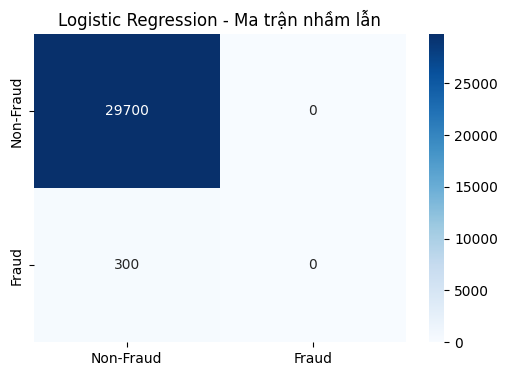


Decision Tree - Độ chính xác: 0.9755333333333334
Decision Tree - Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29700
           1       0.02      0.02      0.02       300

    accuracy                           0.98     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.98      0.98      0.98     30000



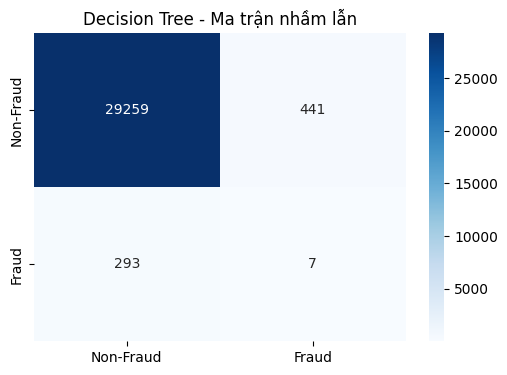

d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


Random Forest - Độ chính xác: 0.99
Random Forest - Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29700
           1       0.00      0.00      0.00       300

    accuracy                           0.99     30000
   macro avg       0.49      0.50      0.50     30000
weighted avg       0.98      0.99      0.99     30000



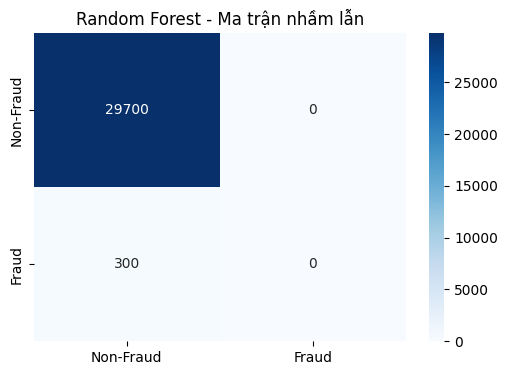

d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Project\credit_card_fraud_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


XGBoost - Độ chính xác: 0.99
XGBoost - Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29700
           1       0.00      0.00      0.00       300

    accuracy                           0.99     30000
   macro avg       0.49      0.50      0.50     30000
weighted avg       0.98      0.99      0.99     30000



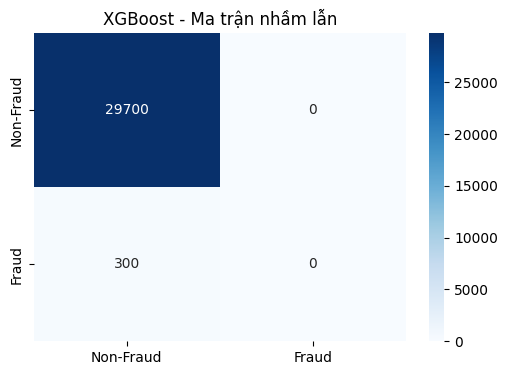

In [27]:
# Danh sách mô hình
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Chia tập dữ liệu và chuẩn hóa
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['IsFraud'])
y = data['IsFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Huấn luyện và đánh giá
results = train_and_evaluate(models, X_train, y_train, X_test, y_test)


In [28]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Giả sử bạn có dữ liệu X (đặc trưng) và y (nhãn)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng PCA để giảm chiều xuống còn 10 thành phần chính
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train_pca)

# Dự đoán trên tập kiểm tra
y_pred_pca = model.predict(X_test_pca)

# Đánh giá mô hình
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
print(f"Độ chính xác của mô hình: {accuracy_pca:.2f}")


Độ chính xác của mô hình: 0.99


## 5. Tối Ưu & Điều Chỉnh Mô Hình
Sau khi đánh giá các mô hình, chúng ta sẽ tối ưu hóa mô hình hoạt động tốt nhất để nâng cao khả năng dự đoán.

**1. Xử Lý Dữ Liệu Mất Cân Bằng**

- SMOTE: Tăng cường dữ liệu lớp thiểu số bằng cách tạo các điểm dữ liệu tổng hợp.
- SMOTE-Tomek: Kết hợp SMOTE với phương pháp giảm dữ liệu không đồng nhất (Tomek Links).
- ADASYN: Tương tự như SMOTE nhưng tập trung vào các điểm khó phân biệt hơn.
- NearMiss: Lấy mẫu ngược (undersampling) lớp chính để cân bằng tỷ lệ.

**2. Tinh Chỉnh Tham Số Mô Hình**

- RandomizedSearchCV: Dò tìm nhanh các kết hợp tham số trong một không gian được chỉ định.
- GridSearchCV: Tìm kiếm kỹ lưỡng trong tất cả các tổ hợp tham số.
- Optuna: Tối ưu hóa hiệu quả với cách tiếp cận Bayesian hiện đại.
- Bayesian Optimization: Cân bằng giữa khám phá và khai thác không gian tham số.

In [29]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Áp dụng SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)

# Áp dụng ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Áp dụng NearMiss
near_miss = NearMiss(version=1)
X_train_nearmiss, y_train_nearmiss = near_miss.fit_resample(X_train, y_train)

X_train_list = [X_train, X_train_smote, X_train_smote_tomek, X_train_adasyn, X_train_nearmiss]
y_train_list = [y_train, y_train_smote, y_train_smote_tomek, y_train_adasyn, y_train_nearmiss]

In [30]:
# Print the count before SMOTE
print("Before SMOTE:")
print(f"Train Data - Positive class (Fraud): {y_train.sum()} | Negative class (Non-Fraud): {(y_train == 0).sum()}")
print(f"Test Data - Positive class (Fraud): {y_test.sum()} | Negative class (Non-Fraud): {(y_test == 0).sum()}")
# Print the count after SMOTE
print("\nAfter SMOTE (Training Data):")
print(f"Train Data - Positive class (Fraud): {y_train_smote.sum()} | Negative class (Non-Fraud): {(y_train_smote == 0).sum()}")
print(f"Train Data Shape: {X_train_smote.shape}")

# Print the count after SMOTE-Tomek
print("\nAfter SMOTE-Tomek (Training Data):")
print(f"Train Data - Positive class (Fraud): {y_train_smote_tomek.sum()} | Negative class (Non-Fraud): {(y_train_smote_tomek == 0).sum()}")
print(f"Train Data Shape: {X_train_smote_tomek.shape}")

# Print the count after ADASYN
print("\nAfter ADASYN (Training Data):")
print(f"Train Data - Positive class (Fraud): {y_train_adasyn.sum()} | Negative class (Non-Fraud): {(y_train_adasyn == 0).sum()}")
print(f"Train Data Shape: {X_train_adasyn.shape}")

# Print the count after NearMiss
print("\nAfter NearMiss (Training Data):")
print(f"Train Data - Positive class (Fraud): {y_train_nearmiss.sum()} | Negative class (Non-Fraud): {(y_train_nearmiss == 0).sum()}")
print(f"Train Data Shape: {X_train_nearmiss.shape}")


Before SMOTE:
Train Data - Positive class (Fraud): 700 | Negative class (Non-Fraud): 69300
Test Data - Positive class (Fraud): 300 | Negative class (Non-Fraud): 29700

After SMOTE (Training Data):
Train Data - Positive class (Fraud): 69300 | Negative class (Non-Fraud): 69300
Train Data Shape: (138600, 11)

After SMOTE-Tomek (Training Data):
Train Data - Positive class (Fraud): 69300 | Negative class (Non-Fraud): 69300
Train Data Shape: (138600, 11)

After ADASYN (Training Data):
Train Data - Positive class (Fraud): 69040 | Negative class (Non-Fraud): 69300
Train Data Shape: (138340, 11)

After NearMiss (Training Data):
Train Data - Positive class (Fraud): 700 | Negative class (Non-Fraud): 700
Train Data Shape: (1400, 11)


Train Data Shape: (70000, 11)


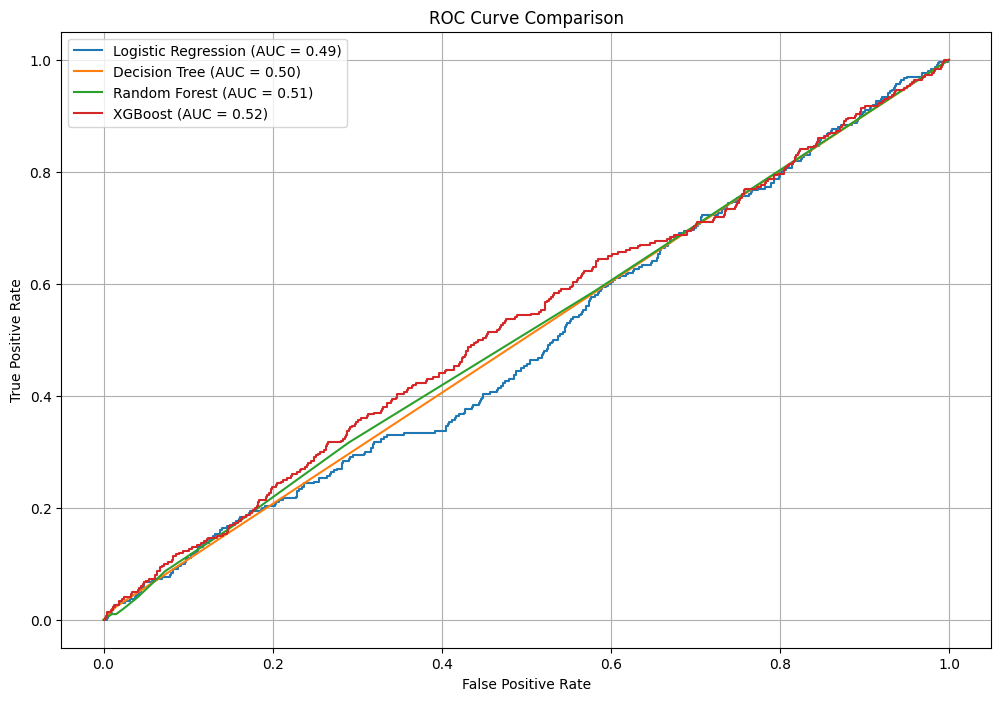

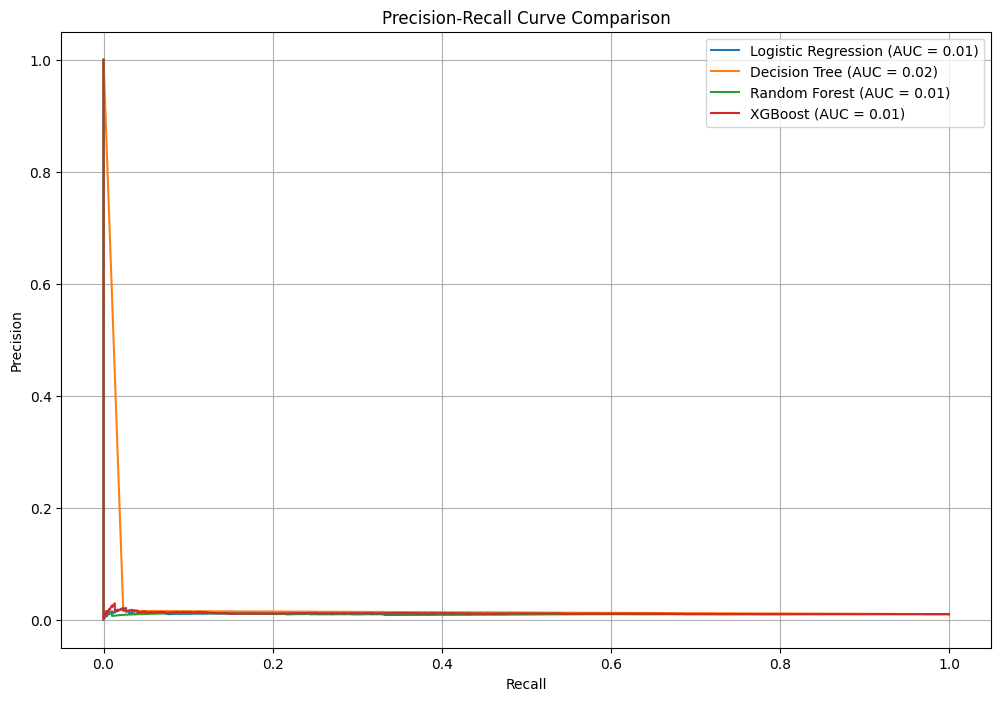

Summary Results:
Model		Training Time (s)	ROC AUC		Precision-Recall AUC
Logistic Regression  0.0981 		 0.4924 		 0.0101
Decision Tree        1.6067 		 0.5042 		 0.0244
Random Forest        26.3975 		 0.5100 		 0.0104
XGBoost              0.5429 		 0.5249 		 0.0112


Train Data Shape: (138600, 11)


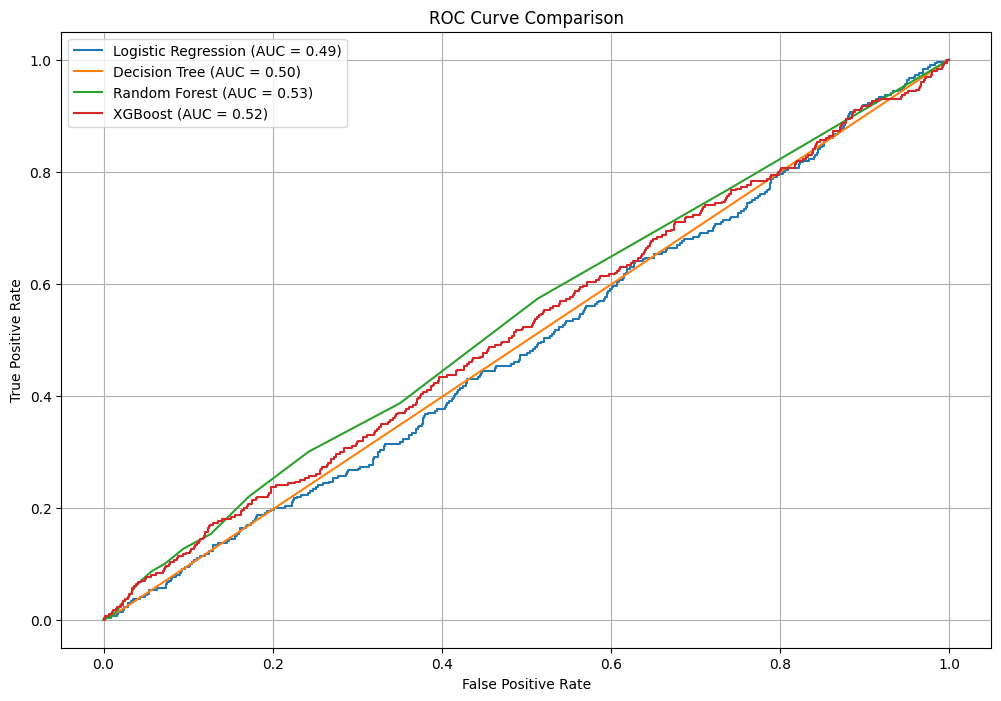

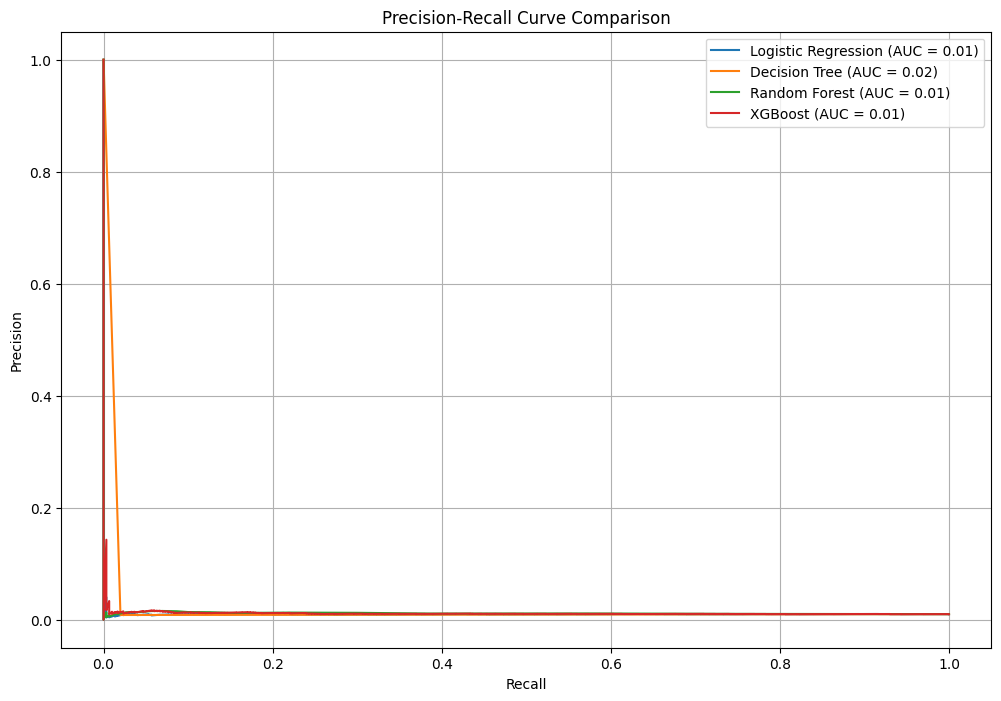

Summary Results:
Model		Training Time (s)	ROC AUC		Precision-Recall AUC
Logistic Regression  0.3566 		 0.4895 		 0.0096
Decision Tree        4.2458 		 0.4981 		 0.0191
Random Forest        95.6994 		 0.5349 		 0.0114
XGBoost              0.9353 		 0.5173 		 0.0112


Train Data Shape: (138600, 11)


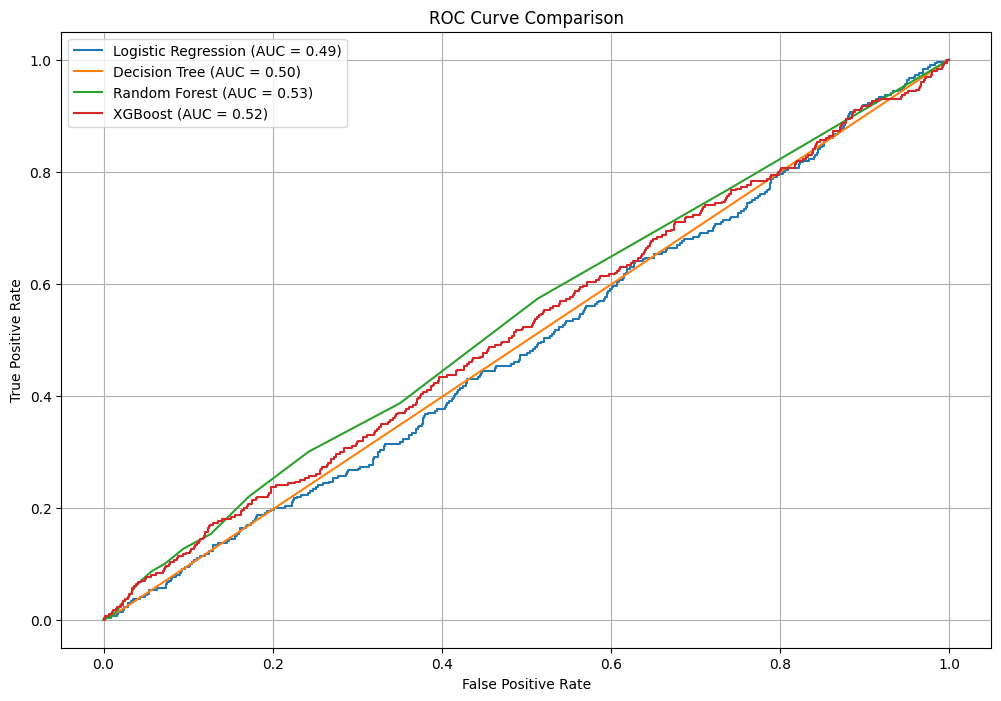

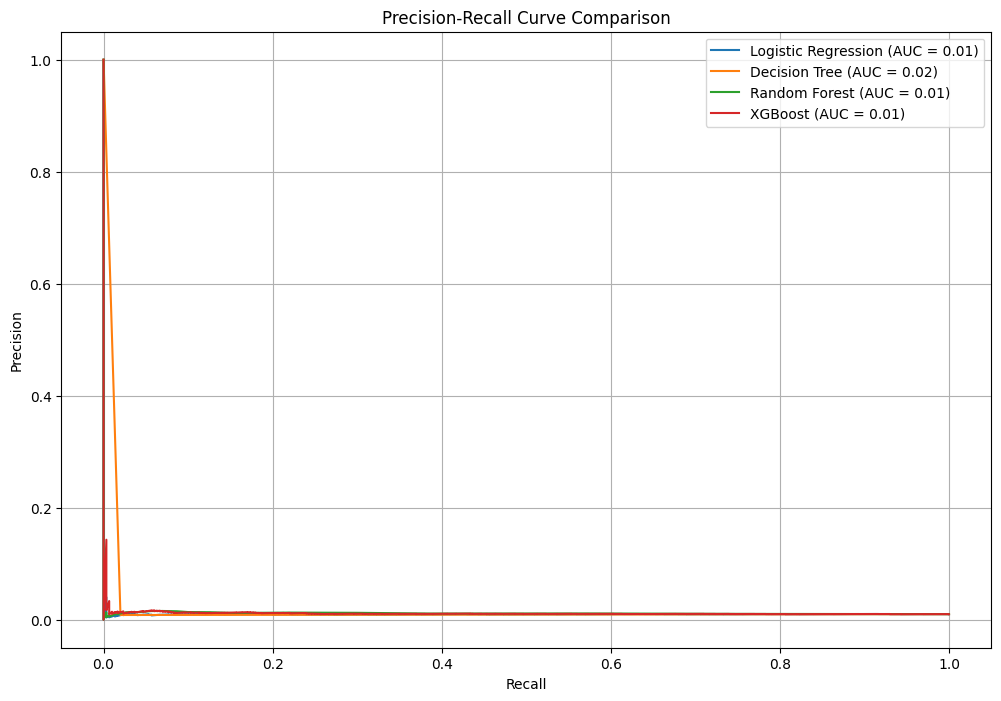

Summary Results:
Model		Training Time (s)	ROC AUC		Precision-Recall AUC
Logistic Regression  0.1710 		 0.4895 		 0.0096
Decision Tree        4.3821 		 0.4981 		 0.0191
Random Forest        97.9351 		 0.5349 		 0.0114
XGBoost              1.1175 		 0.5173 		 0.0112


Train Data Shape: (138340, 11)


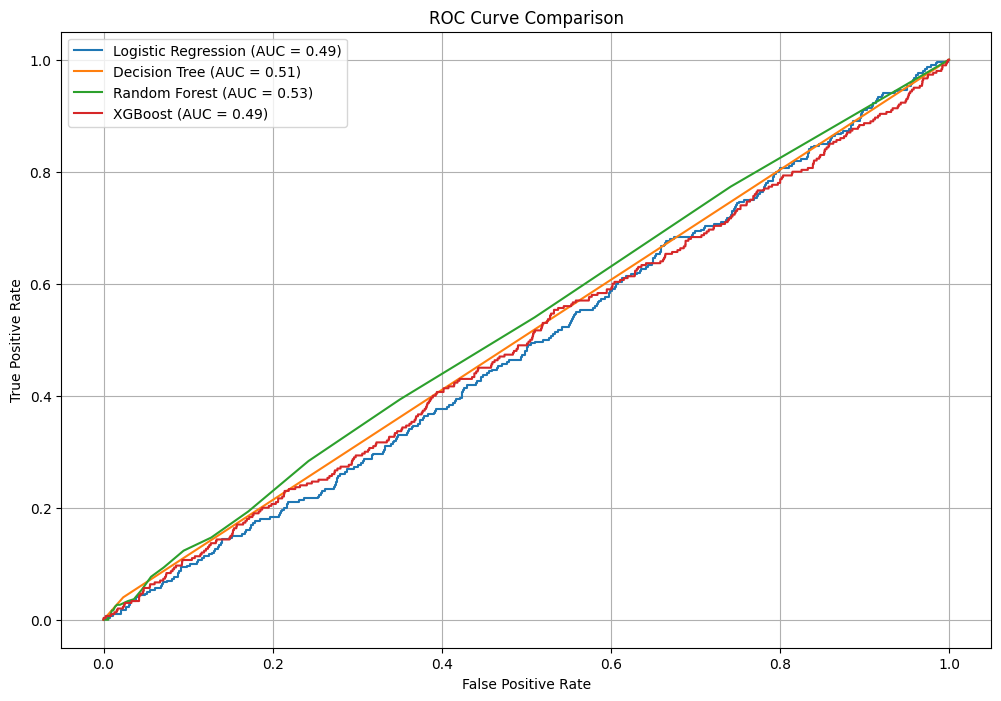

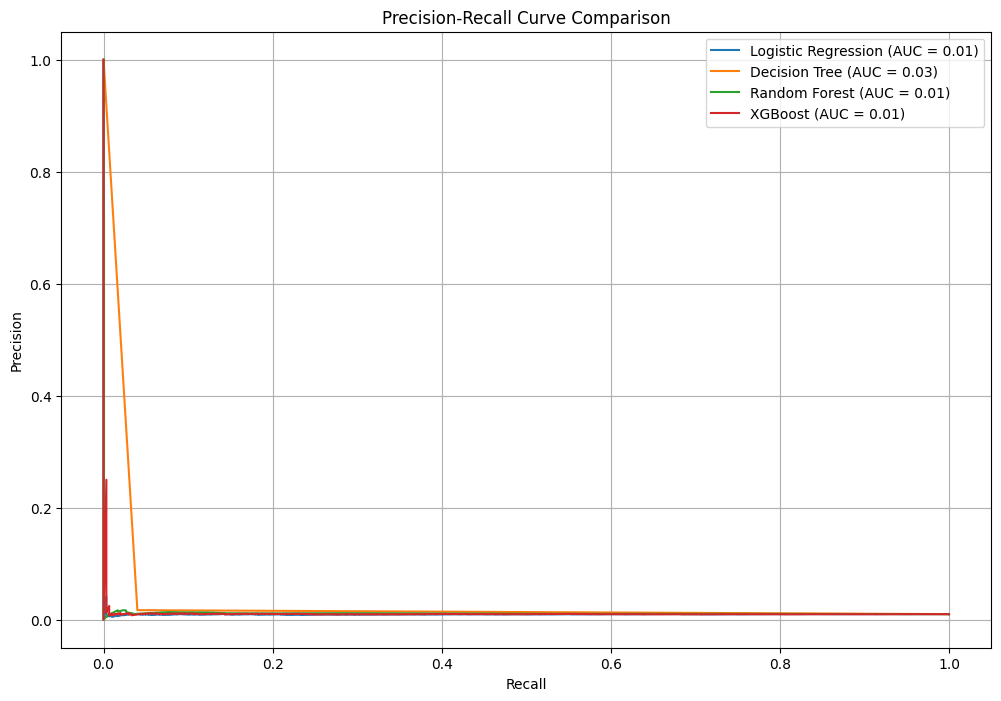

Summary Results:
Model		Training Time (s)	ROC AUC		Precision-Recall AUC
Logistic Regression  0.3217 		 0.4890 		 0.0096
Decision Tree        4.0920 		 0.5084 		 0.0333
Random Forest        92.0342 		 0.5268 		 0.0110
XGBoost              1.6272 		 0.4941 		 0.0104


Train Data Shape: (1400, 11)


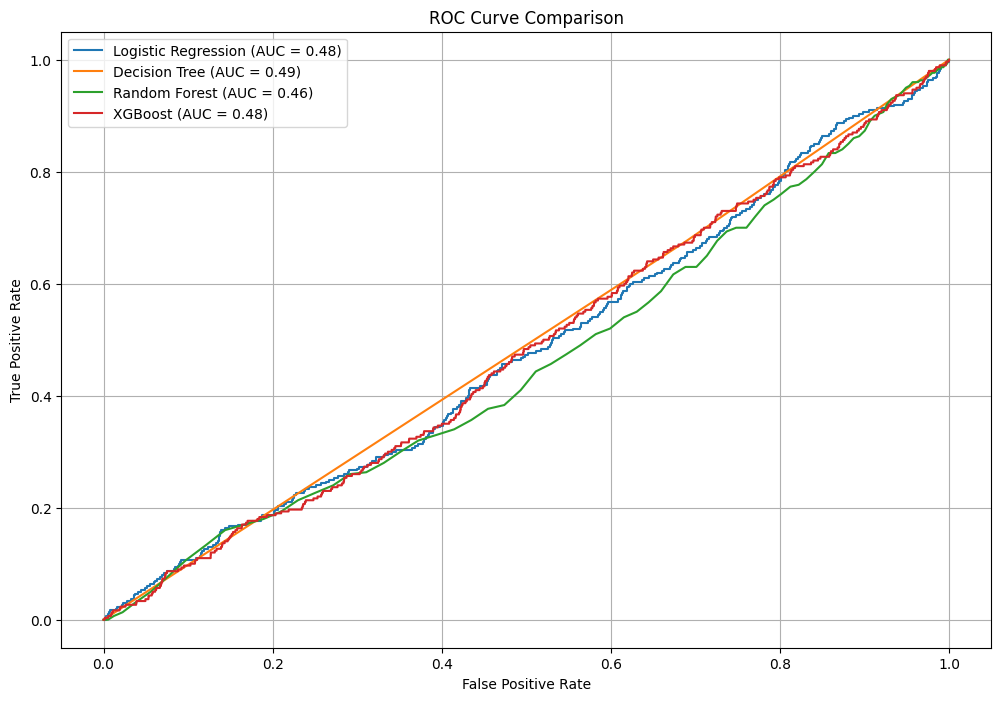

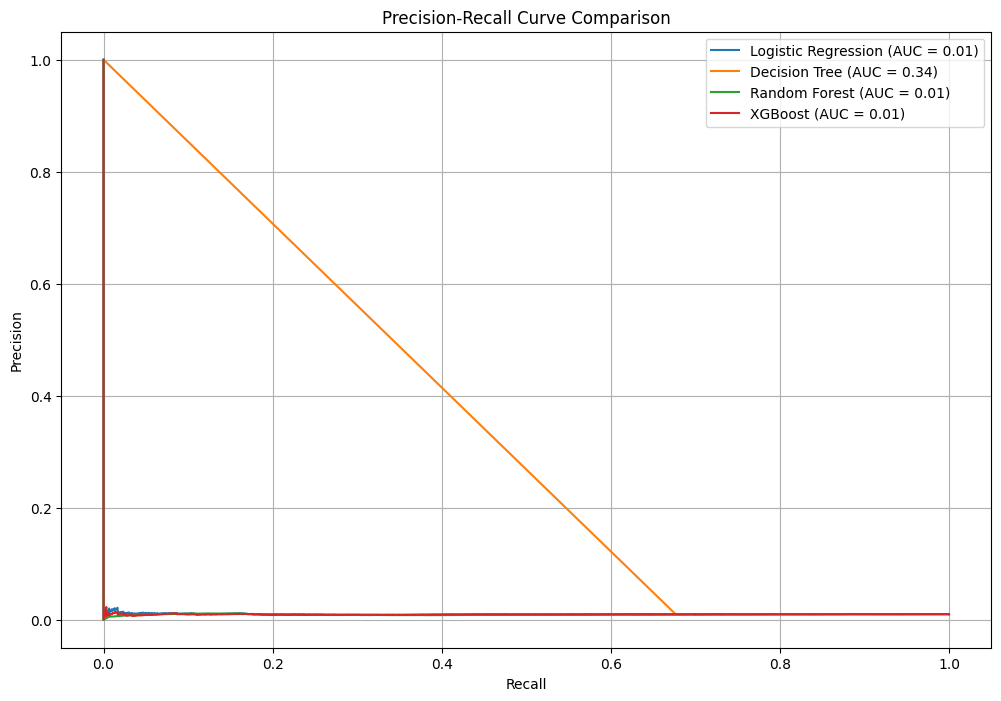

Summary Results:
Model		Training Time (s)	ROC AUC		Precision-Recall AUC
Logistic Regression  0.0195 		 0.4812 		 0.0098
Decision Tree        0.0428 		 0.4935 		 0.3449
Random Forest        1.7742 		 0.4608 		 0.0092
XGBoost              0.1897 		 0.4813 		 0.0095




In [36]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import time

# Định nghĩa các mô hình cơ sở
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')  # Bỏ tham số use_label_encoder
}

# Thêm các mô hình vào
models = {**base_models}

# Huấn luyện và đánh giá mô hình
def train_and_evaluate_with_graphs(models, X_train, y_train, X_test, y_test):
    results = {}
    plt.figure(figsize=(12, 8))

    for name, model in models.items():
        start_time = time.time()

        # Huấn luyện mô hình
        model.fit(X_train, y_train)

        # Dự đoán
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # Tính toán thời gian huấn luyện
        training_time = time.time() - start_time

        # Đánh giá
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        precision, recall, _ = precision_recall_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
        pr_auc = auc(recall, precision) if recall is not None else None

        # Lưu kết quả
        results[name] = {
            "training_time": training_time,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc
        }

        # Vẽ đường ROC
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # Hiển thị đồ thị ROC-AUC
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Vẽ Precision-Recall Curve
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        if "pr_auc" in result and result["pr_auc"] is not None:
            precision, recall, _ = precision_recall_curve(y_test, models[name].predict_proba(X_test)[:, 1])
            plt.plot(recall, precision, label=f"{name} (AUC = {result['pr_auc']:.2f})")

    plt.title("Precision-Recall Curve Comparison")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

    # Hiển thị kết quả bảng
    print("Summary Results:")
    print("Model\t\tTraining Time (s)\tROC AUC\t\tPrecision-Recall AUC")
    for name, result in results.items():
        print(f"{name:20s} {result['training_time']:.4f} \t\t {result['roc_auc']:.4f} \t\t {result['pr_auc']:.4f}")

    return results

# Vòng lặp qua các bộ dữ liệu huấn luyện khác nhau
for X_train, y_train in zip(X_train_list, y_train_list):
    print(f"Train Data Shape: {X_train.shape}")
    results = train_and_evaluate_with_graphs(models, X_train, y_train, X_test, y_test)
    print("\n" + "="*100 + "\n")
